<a href="https://colab.research.google.com/github/testrDEV/NLP_Tweet_Disaster/blob/main/Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pwd

/content


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
stemmer = nltk.SnowballStemmer("english")

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM,Embedding, BatchNormalization,Dense, TimeDistributed, 
                          Dropout,  Bidirectional, Flatten,GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)
from sklearn.pipeline import Pipeline



primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pwd

/content


In [ ]:
df = pd.read_csv("gdrive/MyDrive/notebook/train.csv", encoding="latin-1")
test_df = pd.read_csv("gdrive/MyDrive/notebook/test.csv", encoding="latin-1")

df = df.dropna(how="any", axis=1)
df['text_len'] = df['text'].apply(lambda x: len(x.split(' ')))

df.head()

,id,text,target,text_len
0,1,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,Forest fire near La Ronge Sask. Canada,1,7
2,5,All residents asked to 'shelter in place' are ...,1,22
3,6,"13,000 people receive #wildfires evacuation or...",1,9
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17


## EDA

In [ ]:
fig = go.Figure()
balance_counts = df.groupby('target')['target'].agg('count').values
fig.add_trace(go.Bar(
    x=['Fake'],
    y=[balance_counts[0]],
    name='Fake Tweet',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['Real disaster'],
    y=[balance_counts[1]],
    name='Real disaster',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.show()

Text(0.5, 0.98, 'Characters in tweets')

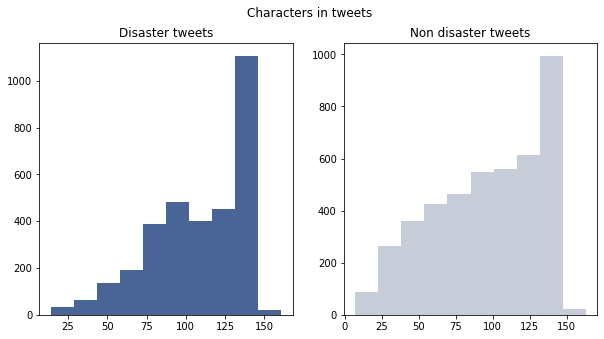

In [ ]:
#Number of characters in tweets
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = df[df['target']==1]['text'].str.len()
ax1.hist(tweet_len,color= primary_blue)
ax1.set_title('Disaster tweets')
tweet_len = df[df['target']==0]['text'].str.len()
ax2.hist(tweet_len,color=primary_grey)
ax2.set_title('Non disaster tweets')
fig.suptitle('Characters in tweets')

Text(0.5, 0.98, 'Characters in tweets')

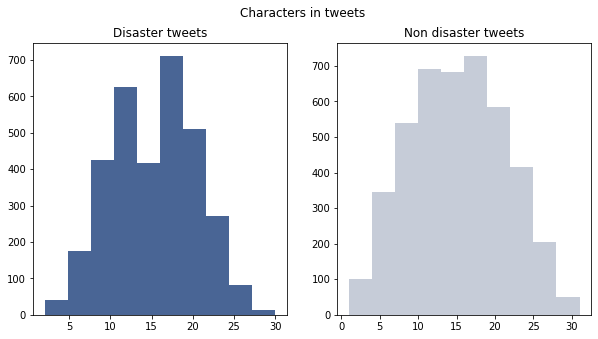

In [ ]:
#Number of words per tweets
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = df[df['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color=primary_blue)
ax1.set_title('Disaster tweets')
tweet_len = df[df['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color=primary_grey)
ax2.set_title('Non disaster tweets')
fig.suptitle('Characters in tweets')

Text(0.5, 0.98, 'Average word length in each tweet')

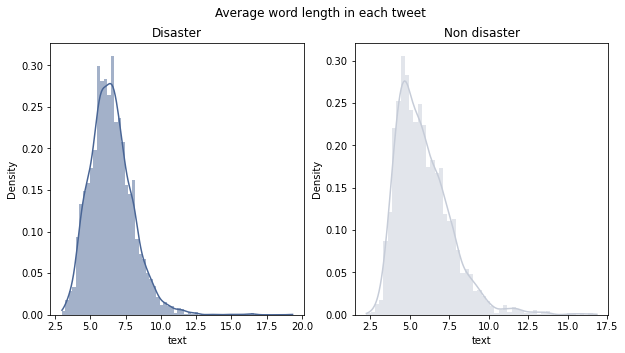

In [ ]:
#Avg word length per tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word = df[df['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax1,color= primary_blue,kde=True, stat="density", linewidth=0)
ax1.set_title('Disaster')
word = df[df['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax2,color= primary_grey,kde=True, stat="density", linewidth=0)
ax2.set_title('Non disaster')
fig.suptitle('Average word length in each tweet')

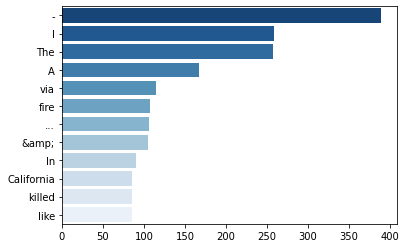

In [ ]:
def create_corpus(target):
    corpus=[]
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus


#Common words
corpus = create_corpus(1)
counter = Counter(corpus)
most = counter.most_common()
x=[]
y=[]
for word, count in most[:40]:
    if (word not in stop_words) :
        x.append(word)
        y.append(count)
sns.barplot(x=y, y=x, palette= 'Blues_r')



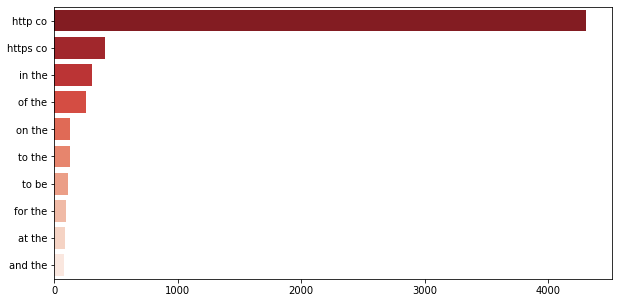

In [ ]:
#Bigram analysis
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
plt.figure(figsize=(10,5))
top_tweet_bigrams = get_top_tweet_bigrams(df['text'])[:10]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x, palette='Reds_r')

### Pre Processing

In [ ]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

# from https://www.kaggle.com/tanulsingh077 
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', 
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    
    return text

In [ ]:

more_stopwords = ['u', 'im', 'c', 'â']
stop_words = stop_words + more_stopwords

def preprocess_data(text):
    # Clean punctuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords and Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' ') if word not in stop_words)

    return text

In [ ]:
test_df['text_clean'] = test_df['text'].apply(preprocess_data)

df['text_clean'] = df['text'].apply(preprocess_data)
df.head()

,id,text,target,text_len,text_clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquak may allah forgiv us
1,4,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask canada
2,5,All residents asked to 'shelter in place' are ...,1,22,resid ask shelter place notifi offic evacu she...
3,6,"13,000 people receive #wildfires evacuation or...",1,9,peopl receiv wildfir evacu order california
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo rubi alaska smoke wildfir pour ...


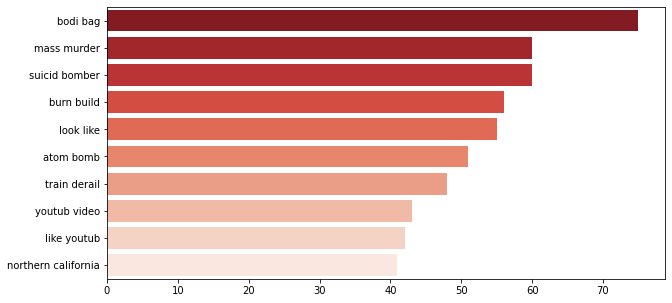

In [ ]:
plt.figure(figsize=(10,5))
top_tweet_bigrams = get_top_tweet_bigrams(df['text_clean'])[:10]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x, palette='Reds_r')

In [ ]:
def create_corpus_df(tweet, target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text_clean'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [ ]:
corpus_disaster_tweets = create_corpus_df(df, 1)

dic=defaultdict(int)
for word in corpus_disaster_tweets:
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('fire', 266),
 ('bomb', 179),
 ('kill', 158),
 ('news', 132),
 ('via', 121),
 ('flood', 120),
 ('disast', 116),
 ('california', 115),
 ('crash', 110),
 ('suicid', 110)]

In [ ]:
corpus_nondisaster_tweets = create_corpus_df(df, 0)

dic=defaultdict(int)
for word in corpus_nondisaster_tweets:
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('like', 306),
 ('get', 222),
 ('amp', 192),
 ('new', 168),
 ('go', 142),
 ('dont', 139),
 ('one', 134),
 ('bodi', 116),
 ('love', 115),
 ('bag', 108)]

### Feature Extraction (Vectorization/Embedding/0 Padding)

In [ ]:
train_tweets = df['text_clean'].values
test_tweets = test_df['text_clean'].values
train_target = df['target'].values

In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

13704

In [ ]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [ ]:
longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train_tweets), 
    length_long_sentence, 
    padding='post'
)
test_padded_sentences = pad_sequences(
    embed(test_tweets), 
    length_long_sentence,
    padding='post'
)

test_padded_sentences

array([[ 194, 1636,   55, ...,    0,    0,    0],
       [ 377,  201,  805, ...,    0,    0,    0],
       [ 136,    2,  583, ...,    0,    0,    0],
       ...,
       [ 757,  519,   53, ...,    0,    0,    0],
       [4838,  175,  127, ...,    0,    0,    0],
       [4607,  635, 1329, ...,    0,    0,    0]], dtype=int32)

In [ ]:
#GLoVe Embedding 100D
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('/content/gdrive/MyDrive/notebook/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [ ]:
# load embedding vectors of those words that appear in the Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       [-0.26872   , -0.15542001, -0.23565   , ...,  0.49344   ,
         0.72114003, -0.041749  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19814   , -0.33517   , -0.13950001, ..., -0.070356  ,
        -0.18391   ,  0.62439001],
       [-0.34132001,  0.26423001,  0.47813001, ..., -0.92395002,
         0.48275   ,  0.52947998]])

In [ ]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    train_target, 
    test_size=0.25
)

In [ ]:
def lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 100)           1370400   
                                                                 
 bidirectional (Bidirectiona  (None, 23, 46)           22816     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 46)               0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 46)               184       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 46)                0         
                                                        

In [ ]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs =7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
178/179 [============================>.] - ETA: 0s - loss: 0.6051 - accuracy: 0.6796
Epoch 1: val_loss improved from inf to 0.58744, saving model to model.h5
179/179 [==============================] - 16s 54ms/step - loss: 0.6057 - accuracy: 0.6791 - val_loss: 0.5874 - val_accuracy: 0.7574 - lr: 0.0010
Epoch 2/7
178/179 [============================>.] - ETA: 0s - loss: 0.4949 - accuracy: 0.7797
Epoch 2: val_loss improved from 0.58744 to 0.49419, saving model to model.h5
179/179 [==============================] - 9s 50ms/step - loss: 0.4945 - accuracy: 0.7798 - val_loss: 0.4942 - val_accuracy: 0.7763 - lr: 0.0010
Epoch 3/7
178/179 [============================>.] - ETA: 0s - loss: 0.4363 - accuracy: 0.8090
Epoch 3: val_loss improved from 0.49419 to 0.46935, saving model to model.h5
179/179 [==============================] - 9s 50ms/step - loss: 0.4368 - accuracy: 0.8089 - val_loss: 0.4694 - val_accuracy: 0.7852 - lr: 0.0010
Epoch 4/7
179/179 [==============================] -

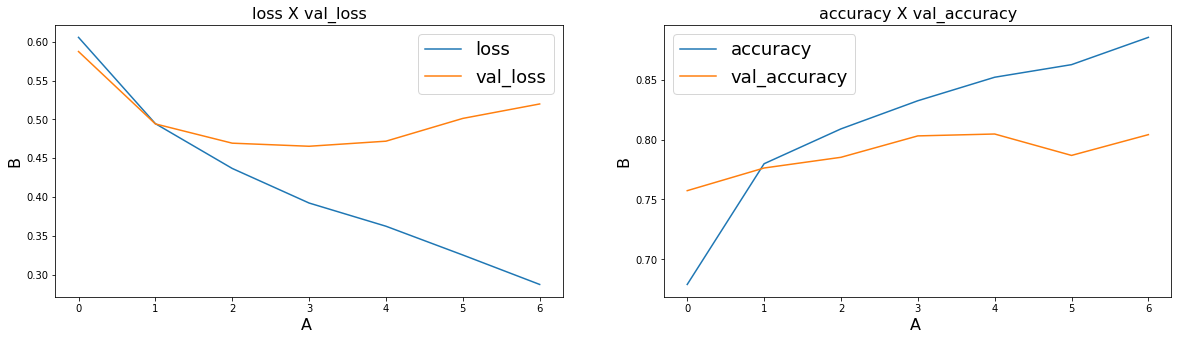

In [ ]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [ ]:
def show_metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
preds = (model.predict(X_test) > 0.5).astype("int32")
show_metrics(preds, y_test)



F1-score:  0.7498323272971161
Precision:  0.6850490196078431
Recall:  0.8281481481481482
Acuracy:  0.8040966386554622
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1229
           1       0.69      0.83      0.75       675

    accuracy                           0.80      1904
   macro avg       0.79      0.81      0.79      1904
weighted avg       0.82      0.80      0.81      1904



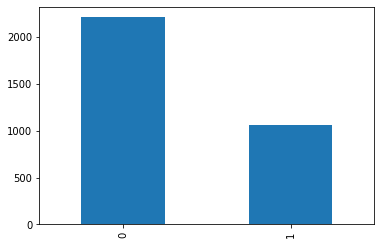

In [ ]:
submission = pd.read_csv('gdrive/MyDrive/notebook/sample_submission.csv')

submission.target = (model.predict(test_padded_sentences) > 0.5).astype("int32")
submission.to_csv("submission.csv", index=False)
submission.target.value_counts().plot.bar();
